# Script 4: broadening spectra

This script uses the utility rotBroad from PyAstronomy. It is a heavy process that requires some time in order to run all the operations, especially with high-resolution and large spectra.


In [1]:
from PyAstronomy import pyasl
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
%matplotlib inline

Reading spectra module. Requires the path where the spectra are located.


In [2]:
def readSpec(filename, path):
    
    sp = fits.open(path + filename)
    header = sp[0].header
      
    tf = sp[0].data
    tf = tf.flatten()
 
    wvl, flx = pyasl.read1dFitsSpec(path + filename)
 
    sp.close()

    date_obs = header['DATE']

    return header, wvl, flx, date_obs, tf
   

Function that broads spectra. Implements rotational broadening as described in D.F. Gray’s book “The Observation and Analysis of Stellar Photospheres”. The limb-darkenkng coeficient is set to a value of 0.59 and the rotational speed can be freely selected.

In [3]:
def broadening (nameSpectrum, allData):
    
    header, wavelength, flux, date_obs, tf = allData
    
    tcrval = header['CRVAL1']
    tcrpix = header['CRPIX1']
    tdelt = header['CDELT1']
    tnumofpix = header['NAXIS1']      

    tw = (np.arange(tnumofpix)-tcrpix)*tdelt + tcrval
    tw = tw.flatten()     
        
    waveini = wavelength[0]
    waveend = wavelength[-1]
    tidx = np.argmin(np.abs(tw - waveini))
    tidx2 = np.argmin(np.abs(tw - waveend))
    print("Limits: "+str(tidx)+" ("+str(waveini)+") "+str(tidx2)+" ("+str(waveend)+")")
    
    tf = tf[tidx:tidx2]
    tw = tw[tidx:tidx2]  
    crval = tw[0]
    header['CRVAL1'] = crval

    broadenvel = float(input('Rotational velocity (km/s):'))
    tfb = pyasl.rotBroad(tw, tf, 0.59, broadenvel)

    filename,filextension = os.path.splitext(nameSpectrum)   
    outfile = filename+"w_"+str(int(broadenvel))+".fits"
    
    return outfile, tfb, header

Function used to save spectra. Some fits headers are modified.

In [4]:
def saveSpec(filename, header, wavelength, flux, date_obs):
    
    header['CRVAL1'] = wavelength[0]
    header['DATE'] = date_obs
    hdu = fits.PrimaryHDU(flux, header)
    hdu.writeto(filename, overwrite=True)  
   

Function to plot spectra. We can change the size modifying the 'figsize' value.


In [5]:
def plotSpectrum(wavelength, flux):

    fig= plt.figure(figsize=(15,5))  
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    axes.plot(wavelength, flux)
    plt.xlabel('wavelength')
    plt.ylabel('flux')
    plt.show()

### Core script.

Main variables and call to all the functions.


Enter spectrum to analyze:ref25000_r
All data


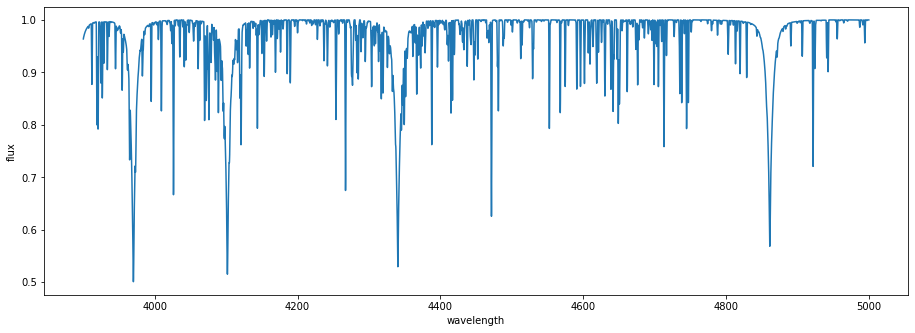

[3900.   3900.01 3900.02 ... 4999.97 4999.98 4999.99]
Do you want to broad the spectrum (y/N)?y
Limits: 1 (3900.0) 109999 (4999.99)
Rotational velocity (km/s):400


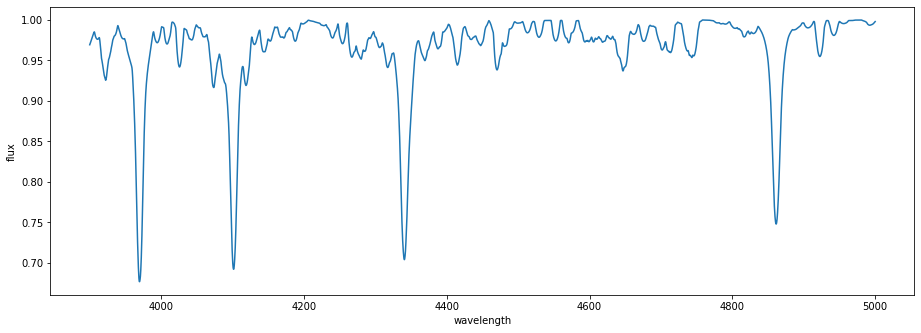

End


In [6]:
path = "/home/fran/PythonProjects/TFM/"

fileSpectrum = input ("Enter spectrum to analyze:")
fileSpectrum += ".fits"

#Reading spectrum
allData = readSpec(fileSpectrum, path)
header, wavelength, flux, date_obs, tf = allData
print("All data")

#Plotting spectrum
plotSpectrum(wavelength, flux)
print(wavelength)

#Broadening spectrum
ask = input("Do you want to broad the spectrum (y/N)?")
if ask =="y" or ask=="Y":
    newSpectrum = broadening(fileSpectrum, allData)
    outfile, tfb, header = newSpectrum 
    saveSpec(outfile, header, wavelength, tfb, date_obs)
   
    #Plotting broadened spectrum
    allData = readSpec(outfile, path)
    header, wavelength, flux, date_obs, tf = allData
    plotSpectrum(wavelength, flux)     
    
print("End")
